<a href="https://colab.research.google.com/github/Curovearth/Cell-Segmentation-and-Denoising/blob/main/Cell_Segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Cell Segmentation in Microscopy Images**


---

**Dataset Used**: The dataset that we have used here is [kaggle 2018 Data Science Bowl contest dataset](https://www.kaggle.com/c/data-science-bowl-2018),which contains 670 images of cells along with its masks. Each image in the dataset is assigned with an average of 20 images that adds up to become the mask of that single image and there are such 670 images in the dataset.
For our own ease we have saved the created masked files into a separate folder along with the image. Such that we can save the computation time required to join those masks into a single mask eachtime we run the notebook

In [1]:
! nvidia-smi    # To check the number of GPUs with their names

Fri Aug 19 17:53:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.2


---
## Setup and Importing Libraries

In [3]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

*   `Sequence` → safer way to do multiprocessing. Structure gurantees that the network will only train once on each sample per epoch.
* `tensorflow.keras.callbacks` → Callbacks can be passed to keras methods such as fit , evaluate , and predict in order to hook into the various stages of the model training

In [4]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



*   `sklearn.metrics` → module implements several loss, score and utility functions to measure classification performance.
*   `albumentations` → CV tool that boosts the performance of DNN and mainly used for fast and flexible image augmentations.



In [5]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [6]:
from albumentations import (Compose, OneOf, 
                            CLAHE, Flip,Rotate,Transpose,ShiftScaleRotate,IAAPiecewiseAffine,RandomRotate90,ChannelShuffle,ElasticTransform,Flip,GridDistortion,HorizontalFlip,HueSaturationValue,OpticalDistortion,
                            RandomBrightnessContrast,RandomGamma,RandomSizedCrop,VerticalFlip,RGBShift,GaussNoise )

---


Now, we mount our google drive to access the dataset which was downloaded and exported to the drive folder.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
print('---------------------- Directories ----------------------\n')
for dirname, _, filenames in os.walk('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data'):
  print(dirname)

---------------------- Directories ----------------------

/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/test
/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images


In [9]:
train_image_dir = r'/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images'   # training images directory
train_mask_dir = r'/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks'     # mask images directory

In [10]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

Number of training images :  670
Number of training masks :  670


---
### Shuffling 

`random.shuffle` → method takes a sequence which in our case is a list of path to images and reorganises randomly the order of items.

Further training_image_paths and training_mask_paths are also combined

In [35]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
print(f'Length of combined: {len(combined)}')
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)
print(list(combined[:20]))

Length of combined: 670
[('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/591.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/591.png'), ('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/85.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/85.png'), ('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/341.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/341.png'), ('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/445.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/445.png'), ('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/326.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/326.png'), ('/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/538.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/538.png'), ('/content/drive/MyDrive/LSM and TA

> Following is how actually the zip() works in python and it's only shown here for reference.

In [12]:
# example of working of zip() in python

numbers=[1,2,3]
letters=['a','b','c']
zipped = zip(numbers, letters)
print(zipped)
print(list(zipped))

[(1, 'a'), (2, 'b'), (3, 'c')]


---

In [13]:
print("After shuffling")
print(f'Length: {len(train_image_paths)} ',train_image_paths[0:5])
print(f'Length: {len(train_mask_paths)} ',train_mask_paths[0:5])
# Sequence intact !

After shuffling
Length: 670  ['/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/480.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/408.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/223.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/222.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/images/454.png']
Length: 670  ['/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/480.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/408.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/223.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/222.png', '/content/drive/MyDrive/LSM and TARP /Cell Segmentation Data/masks/454.png']


In [14]:
# Splitting
train_image_files = train_image_paths[:500]   # First 500 image path
train_mask_files = train_mask_paths[:500]     # First 500 mask image path

valid_image_files = train_image_paths[500:]   # Last 170 image path
valid_mask_files = train_mask_paths[500:]     # Last 170 mask image path

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


500 500
170 170


---
Follow image processing takes place for both Training images as well Maked images using PIL or Python Image Library
*   Conversion to RGB
*   resizing it to 256*256
*   converting the image to numpy array



In [15]:
def read_image(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.convert('RGB')
    img = img.resize(dim)
    img = np.array(img)
    return img

In [16]:
def read_mask(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    img = (img>0).astype(np.uint8)
    return img

---
### Augmentation and Precprocessing

Training data was augmented using [Albumentations Library](https://albumentations.ai/). A strong combination of different types of image augmentations were applied with varied probabilities.

*   `CLAHE` → **Contrast limited adaptive histogram equalization**: Takes care of over-amplification of the contrast. Operates on small regions in the image, rather than the entire image. [Ref](https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2)
*   Rotate
*   Flip
*   `GaussNoise` → Adding gaussian noise to the image
*   HorizontalFlip
*   VerticalFlip
*   HueSaturationValue
*   RandomGamma
*   Random Brightness and Contrast

For more visualisation, refer [Data Augmentation Tutorial](https://tugot17.github.io/data-science-blog/albumentations/data-augmentation/tutorial/2020/09/20/Pixel-level-transforms-using-albumentations-package.html#RandomGamma)



    Rotation, Gaussian Noise, Crop, Hue and Saturation, Elastic Transform, Coarse Dropout


Example Image

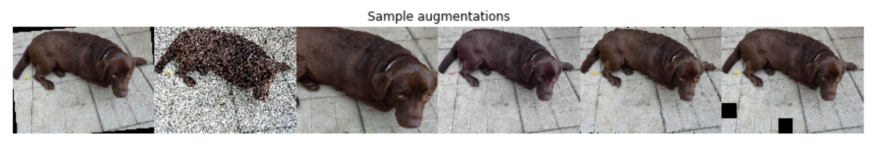

In [17]:
class Train_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)
  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0), 
      Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      Flip(always_apply = True),
      OneOf([
             GaussNoise()
             ], p=0.9),
      OneOf([
             HorizontalFlip()
                 
      ], p=0.6),
      
      OneOf([
             
             RandomBrightnessContrast(),
             RandomGamma()
             ], p=0.2),
     OneOf([VerticalFlip()],p=0.7)
     ,
     OneOf([HueSaturationValue()],p=0.5)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [18]:
class Val_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
       k=math.ceil(len(self.x) / self.batch_size)
      #  print(k)
      #  print(len(self.x))
      #  print(self.batch_size)
       return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
      # print(batch_x)
      # print(batch_y)

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])
      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [19]:
train_generator = Train_Generator(train_image_files, train_mask_files)
valid_generator = Val_Generator(valid_image_files, valid_mask_files)

In [20]:
# Finally in 3 dims

for i, j in train_generator:
  print(i.dtype)
  print(j.dtype)
  break

float64
float64


In [21]:
for i, j in train_generator:
  print(i.shape)
  print(j.shape)
  break

(10, 256, 256, 3)
(10, 256, 256, 1)


---
### Some Sample Images and their masks
> masks displayed in the next block of code

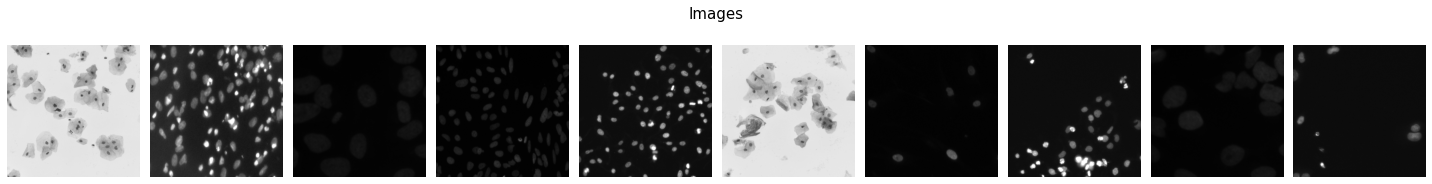

In [22]:
fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


### Masks

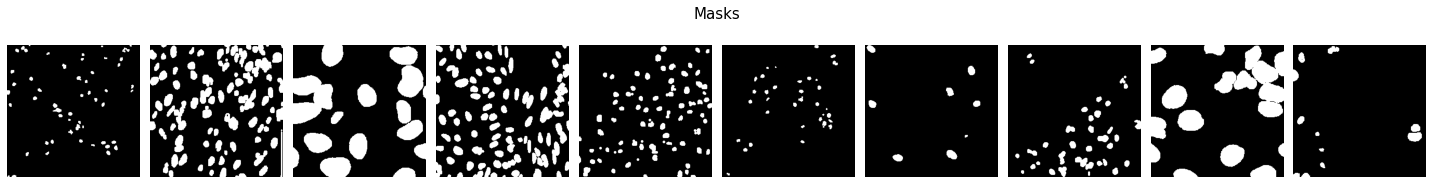

In [23]:

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
def train_generator():
  return Train_Generator(train_image_files, train_mask_files, augmentation=True)
def valid_generator():
  return Val_Generator(valid_image_files, valid_mask_files, augmentation=True)


In [25]:
ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()

In [26]:
 train_generator_aug = Train_Generator(train_image_files, train_mask_files,augmentation=True)

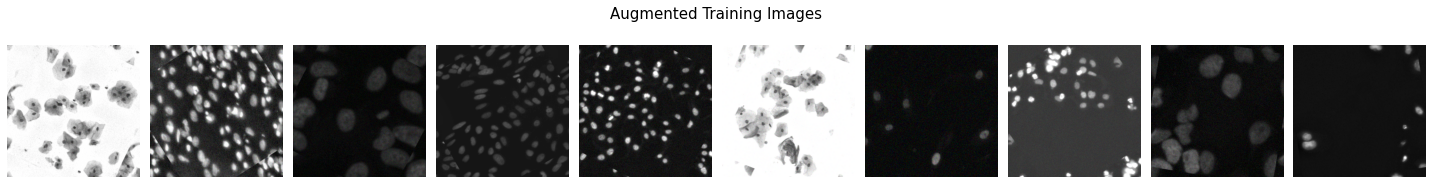

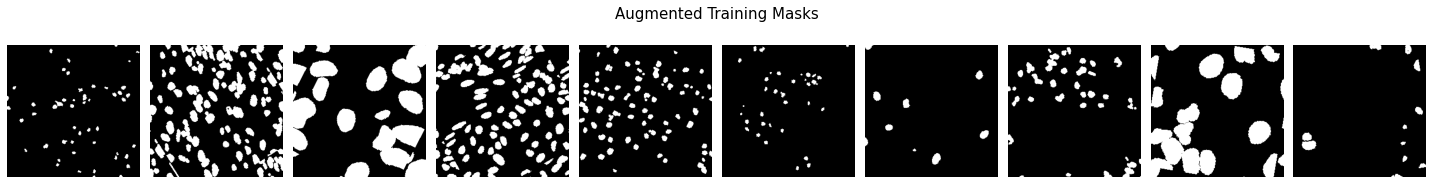

In [27]:
# Augmented training set
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [28]:
 valid_generator_aug= Val_Generator(valid_image_files, valid_mask_files,augmentation=True)

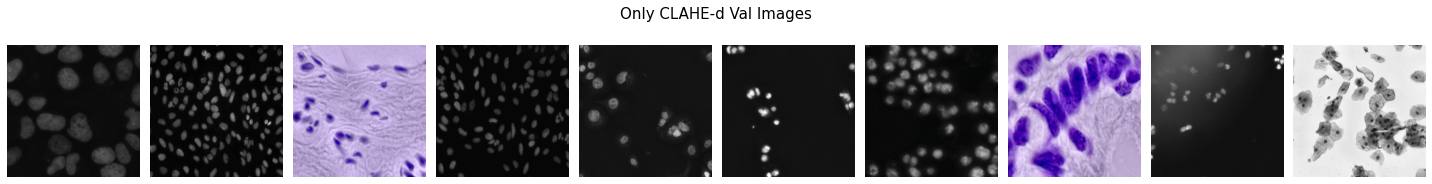

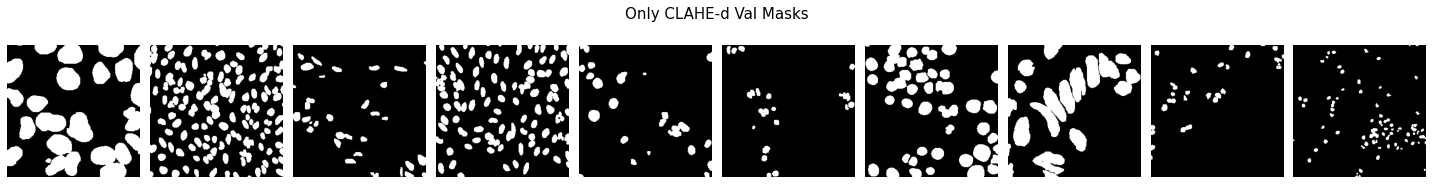

In [29]:
# Augmented val set
for i, j in ds_valid:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [30]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = y_true * y_pred
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou(y_true, y_pred):
    thresh = 0.5
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')
    intersection = K.sum(K.minimum(y_true, y_pred)) + smooth
    union = K.sum(K.maximum(y_true, y_pred)) + smooth
    iou = intersection/union
    return iou

---
## Network Architecture

When it comes to medical imaging, margin of error should be almost negligible. One small mistake can lead to even fatal outcomes. 

Thus, algorithms designed for medical imaging must achieve high performance and accuracy even if the total number of training samples upon which the data is trained is not enough. 

To solve this issue, [UNet](https://link.springer.com/article/10.1007/s10462-022-10152-1) and [UNet arxiv](https://arxiv.org/abs/1505.04597) was introduced in the domain of AI based medical imaging world, which gave unexpectedly good results.

The model architecture that we tried implementing is UNet++. It has 3 additions in comparison to the classic UNet:

* having convolution layers on skip pathways, which bridges the semantic gap between encoder and decoder feature maps.
* having dense skip connections on skip pathways, which improves gradient flow.
* having deep supervision, which enables model pruning and improves or in the worst case achieves comparable performance to using only one loss layer.


`DenseBlock` → module used in convolutional neural networks that connects all layers 

> Explanation on Encoder Decoder Model: [Encoder and Decoder](https://towardsdatascience.com/what-is-an-encoder-decoder-model-86b3d57c5e1a)

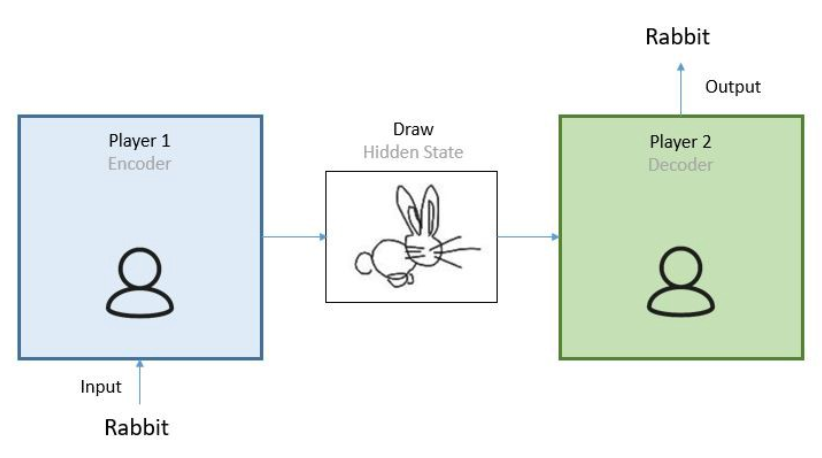

In [31]:
def nested_unet():

  inputs = Input((256,256, 3))

  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0') (inputs)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0_1') (A_conv_0)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_pool_0 = MaxPooling2D((2, 2)) (A_conv_0)

  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0') (A_pool_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0_1') (B_conv_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_pool_0 = MaxPooling2D((2, 2)) (B_conv_0)

  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0') (B_pool_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0_1') (C_conv_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_pool_0 = MaxPooling2D((2, 2)) (C_conv_0)

  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0') (C_pool_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0_1') (D_conv_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_pool_0 = MaxPooling2D((2, 2)) (D_conv_0)

  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0') (D_pool_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0_1') (E_conv_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_pool_0 = MaxPooling2D((2, 2)) (E_conv_0)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_1') (B_conv_0)
  A_conv_1 = concatenate([A_conv_0, A_conv_1], name='A_concat_1')
  A_conv_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_1') (A_conv_1)
  A_conv_1 = BatchNormalization() (A_conv_1)

  B_conv_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_1') (C_conv_0)
  B_conv_1 = concatenate([B_conv_0, B_conv_1], name='B_concat_1')
  B_conv_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_1') (B_conv_1)
  B_conv_1 = BatchNormalization() (B_conv_1)

  C_conv_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_1') (D_conv_0)
  C_conv_1 = concatenate([C_conv_0, C_conv_1], name='C_concat_1')
  C_conv_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_1') (C_conv_1)
  C_conv_1 = BatchNormalization() (C_conv_1)

  D_conv_1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='D_trans_1') (E_conv_0)
  D_conv_1 = concatenate([D_conv_0, D_conv_1], name='D_concat_1')
  D_conv_1 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_1') (D_conv_1)
  D_conv_1 = BatchNormalization() (D_conv_1)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_2') (B_conv_1)
  A_conv_2 = concatenate([A_conv_0, A_conv_1, A_conv_2], name='A_concat_2')
  A_conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_2') (A_conv_2)
  A_conv_2 = BatchNormalization() (A_conv_2)

  B_conv_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_2') (C_conv_1)
  B_conv_2 = concatenate([B_conv_0, B_conv_1, B_conv_2], name='B_concat_2')
  B_conv_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_2') (B_conv_2)
  B_conv_2 = BatchNormalization() (B_conv_2)

  C_conv_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_2') (D_conv_1)
  C_conv_2 = concatenate([C_conv_0, C_conv_1, C_conv_2], name='C_concat_2')
  C_conv_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_2') (C_conv_2)
  C_conv_2 = BatchNormalization() (C_conv_2)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_3') (B_conv_2)
  A_conv_3 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3], name='A_concat_3')
  A_conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_3') (A_conv_3)
  A_conv_3 = BatchNormalization() (A_conv_3)

  B_conv_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_3') (C_conv_2)
  B_conv_3 = concatenate([B_conv_0, B_conv_1, B_conv_2, B_conv_3], name='B_concat_3')
  B_conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_3') (B_conv_3)
  B_conv_3 = BatchNormalization() (B_conv_3)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_4') (B_conv_3)
  A_conv_4 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3, A_conv_4], name='A_concat_4')
  A_conv_4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_4') (A_conv_4)
  A_conv_4 = BatchNormalization() (A_conv_4)

  #-------------------------------------------------------------------------------------------------------------#

  A_out_1 = Conv2D(1, (1, 1), activation='sigmoid',name='out1') (A_conv_1)
  A_out_2 = Conv2D(1, (1, 1), activation='sigmoid',name='out2') (A_conv_2)
  A_out_3 = Conv2D(1, (1, 1), activation='sigmoid',name='out3') (A_conv_3)
  A_out_4 = Conv2D(1, (1, 1), activation='sigmoid',name='out4') (A_conv_4)

  outputs = average([A_out_1, A_out_2, A_out_3, A_out_4])

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

model = nested_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 A_conv_0 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['A_conv_0[0][0]']               
 alization)                     )                                                             

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [37]:
def lr_schedule(epoch):
    lr=0.0001
    # lr =0.001
    if epoch >15:
        lr *=2**-1
    elif epoch >10:
        lr *=2**(-1)
    elif epoch >8:
        lr *=2**(-1)
    elif epoch >5:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [38]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [39]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
# optimiser=tf.keras.optimizers.SGD(
#     learning_rate=lr_schedule(0),

# )
model.compile(optimizer =optimiser , loss = bce_dice_loss, metrics = ['accuracy', iou,'AUC'])

Learning rate:  0.0001


In [ ]:
history = model.fit(
    ds_train, 
    steps_per_epoch=500//10,
    epochs=20,
    validation_data = ds_valid,    
    validation_steps =170//10,callbacks=callbacks
     )